In [1]:
import pandas as pd
import numpy as np
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#import xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import time

### Import Data

In [2]:
train = pd.read_csv("D:/Statastics/Analytics Vidhya/L&T - Vehicle Loan Default/train.csv")
test  = pd.read_csv("D:/Statastics/Analytics Vidhya/L&T - Vehicle Loan Default/test_bqCt9Pv.csv")

In [3]:
train.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [4]:
test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,...,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,...,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


### No of records in Train and Test 

In [5]:
#No of records
print("Train",train.shape)
print("Test",test.shape)

Train (233154, 41)
Test (112392, 40)


### Checking event rate

In [6]:
#Checking event rate for Train
events = train.groupby("loan_default").size()
print("Zero Event:",events[0]/len(train))
print("One Event:",events[1]/len(train))


Zero Event: 0.782928879625
One Event: 0.217071120375


### Exploratory Data Analysis

In [7]:
# Merging train and Test data for EDA
#Adding loan default field with null value
test["loan_default"] = np.nan
#Appending data
train_test = train.append(test)


### Missing Value Imputation

In [8]:
#Checking Missing Values
missing_vars = pd.DataFrame(train_test.isnull().sum())
missing_vars.columns = ["count"]
missing_vars.loc[missing_vars["count"] > 0]

,count
Employment.Type,11104
loan_default,112392


In [9]:
# 1. Loan_default is target variable. It has Nulls, because we merged test and train data
# 2. Only Employment.Type var has nulls

# Checking unique values
print("Distinct Emp Type :",train_test["Employment.Type"].unique())
#Checking missing valus in percentage
print("Missing Emp Type %:",train_test["Employment.Type"].isnull().sum() / len(train_test) * 100)


Distinct Emp Type : ['Salaried' 'Self employed' nan]
Missing Emp Type %: 3.21346506688


In [10]:
# We have only two categories i.e. 'Salaried' 'Self employed'. 
# Missing Emp Type is only 3.21%. 
# Applicant may be unemployed, hence we are imputing missing values as 'other'

# Imputing Employment.Type as Other
train_test["Employment.Type"].fillna("Other", inplace = True)


In [11]:
#Taking Numeric Variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_variable_data = train_test.select_dtypes(include=numerics)
numeric_variables=list(numeric_variable_data)
total_rec=len(numeric_variable_data)

### Quick feature engineering

In [12]:
#FQuick feature Engineering on Numeric data
numeric_variable_data["Pri_amt_difference"] = 1
numeric_variable_data.loc[(numeric_variable_data['PRI.DISBURSED.AMOUNT'] - numeric_variable_data['PRI.SANCTIONED.AMOUNT']) < 0,'Pri_amt_difference'] = 0

numeric_variable_data["Sec_amt_difference"] = 1
numeric_variable_data.loc[(numeric_variable_data['SEC.DISBURSED.AMOUNT'] - numeric_variable_data['SEC.SANCTIONED.AMOUNT']) < 0,'Sec_amt_difference'] = 0
numeric_variables=list(numeric_variable_data)
len(numeric_variables)


C:\Users\Gaurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gaurav\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Gaurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

37

In [13]:
numeric_variable_data.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Pri_amt_difference,Sec_amt_difference
0,420825,50578,58400,89.55,67,22807,45,1441,6,1998,...,0,0,0,0,0,0,0,0.0,1,1
1,537409,47145,65550,73.23,67,22807,45,1502,6,1998,...,0,0,1991,0,0,1,0,1.0,1,1
2,417566,53278,61360,89.63,67,22807,45,1497,6,1998,...,0,0,0,0,0,0,0,0.0,1,1
3,624493,57513,66113,88.48,67,22807,45,1501,6,1998,...,0,0,31,0,0,0,1,1.0,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,6,1998,...,0,0,0,0,0,0,1,1.0,1,1


In [14]:
#Deriving the univariate summary of numeric variables
variable_summary = pd.DataFrame(columns=numeric_variables)
total_rec = numeric_variable_data.shape[0]
for i in numeric_variables:
    NA_Count = len(numeric_variable_data[numeric_variable_data[i].isnull()])
    variable_values = numeric_variable_data[i].dropna()
    mean_value = variable_values.mean()
    quantile_distr = variable_values.quantile([0,0.02,.25,.50,.75,0.98,1])
    quantile_distr = quantile_distr.append(pd.Series([NA_Count,mean_value], index=['NA_Count','mean']))
    variable_summary[i] = quantile_distr
    
    numeric_variable_summary=variable_summary.transpose()
    summary_variables1=['min_value','percentile_02', 'percentile_25', 'median',
                                       'percentile_75', 'percentile_98',
                                       'max_value', 'percent_na_count','mean']
    numeric_variable_summary.columns = summary_variables1
    numeric_variable_summary['percent_na_count']=numeric_variable_summary['percent_na_count']/total_rec*100
    numeric_variable_summary['range']=numeric_variable_summary['max_value']-numeric_variable_summary['min_value']
    numeric_variable_summary['range_02_98']=numeric_variable_summary['percentile_98']-numeric_variable_summary['percentile_02']
    numeric_variable_summary['variable_name']=list(numeric_variable_summary.index)
    numeric_variable_summary.head(10)
    numeric_variable_summary_bkp = numeric_variable_summary
    
    
    unique_variable = list(numeric_variable_summary.loc[numeric_variable_summary.range_02_98==0,'variable_name'])
    remove_variable_list = unique_variable
    final_numerical_variable=[col for col in numeric_variables if col not in remove_variable_list]
    

In [15]:
numeric_variable_summary

,min_value,percentile_02,percentile_25,median,percentile_75,percentile_98,max_value,percent_na_count,mean,range,range_02_98,variable_name
UniqueID,417428.00,424446.9,505386.25,592918.50,680501.75,762757.10,7.699090e+05,0.000000,593106.042648,3.524810e+05,338310.20,UniqueID
disbursed_amount,11613.00,30344.0,47645.00,54303.00,60947.00,86120.00,9.905720e+05,0.000000,54916.377391,9.789590e+05,55776.00,disbursed_amount
asset_cost,37000.00,52900.0,66282.00,71541.00,79605.00,130417.70,1.628992e+06,0.000000,76294.838650,1.591992e+06,77517.70,asset_cost
ltv,10.03,44.6,69.28,77.14,83.69,89.86,9.500000e+01,0.000000,74.929910,8.497000e+01,45.26,ltv
branch_id,1.00,1.0,15.00,64.00,135.00,254.00,2.610000e+02,0.000000,74.876752,2.600000e+02,253.00,branch_id
supplier_id,10524.00,14011.0,16565.00,20470.00,23049.00,24487.00,2.490100e+04,0.000000,19705.205342,1.437700e+04,10476.00,supplier_id
manufacturer_id,45.00,45.0,45.00,86.00,86.00,120.00,1.560000e+02,0.000000,68.812725,1.110000e+02,75.00,manufacturer_id
Current_pincode_ID,1.00,51.0,1449.00,2790.00,5458.00,7143.00,7.345000e+03,0.000000,3272.345381,7.344000e+03,7092.00,Current_pincode_ID
State_ID,1.00,1.0,4.00,6.00,10.00,18.00,2.200000e+01,0.000000,7.247122,2.100000e+01,17.00,State_ID
Employee_code_ID,1.00,74.0,737.00,1511.00,2470.00,3597.00,3.923000e+03,0.000000,1621.741403,3.922000e+03,3523.00,Employee_code_ID


In [16]:
#Converting the flag variables to categorical as they have levels with 0 and 1.
numeric_variable_data_new = numeric_variable_data.loc[:,final_numerical_variable]
categorial_numeric_variable = numeric_variable_summary.loc[numeric_variable_summary.range==1,'variable_name']
numeric_variable_summary = numeric_variable_summary.loc[numeric_variable_summary.range>1,:]
categorial_numeric_data = numeric_variable_data_new.loc[:,categorial_numeric_variable]
final_numerical_variable = list(numeric_variable_data_new)

In [17]:
#Dropping Passport flag & Sec_amt_difference as it has null
categorial_numeric_data.drop(["Passport_flag","Sec_amt_difference"], axis =1, inplace = True)

In [18]:
categorial_numeric_data.head(2)

,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,loan_default,Pri_amt_difference
0,1,0,0,0,0.0,1
1,1,0,0,0,1.0,1


In [19]:
#Creating final numeric variable data
numeric_variable_data_new = numeric_variable_data_new.loc[:,final_numerical_variable]


In [20]:
numeric_variable_data_new.head(3)

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,...,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,PRIMARY.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,Pri_amt_difference
0,420825,50578,58400,89.55,67,22807,45,1441,6,1998,...,0,0,0,0,0,0,0,0,0.0,1
1,537409,47145,65550,73.23,67,22807,45,1502,6,1998,...,27600,50200,50200,0,1991,0,1,0,1.0,1
2,417566,53278,61360,89.63,67,22807,45,1497,6,1998,...,0,0,0,0,0,0,0,0,0.0,1


### Fine Classing

In [60]:
#Fine classing on selected numeric_variables
numeric_variables_fineclassing = ["PRI.NO.OF.ACCTS","PRI.ACTIVE.ACCTS","PRI.OVERDUE.ACCTS","SEC.NO.OF.ACCTS"
                                  ,"SEC.ACTIVE.ACCTS","SEC.OVERDUE.ACCTS","SEC.INSTAL.AMT"
                                  ,"NEW.ACCTS.IN.LAST.SIX.MONTHS","DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS","NO.OF_INQUIRIES"] 

#target = train_test["loan_default"]
fine_classing_data=pd.DataFrame(train_test["loan_default"])

for i in list(numeric_variables_fineclassing):
    variable_values=numeric_variable_data[i]
    quantile_distr=variable_values.quantile([0.20,0.40,0.60,0.80])
    fine_classing_data.loc[variable_values<=quantile_distr[0.20],'cat_'+i]=1
    fine_classing_data.loc[variable_values<=quantile_distr[0.40],'cat_'+i]=2
    fine_classing_data.loc[variable_values<=quantile_distr[0.60],'cat_'+i]=3
    fine_classing_data.loc[variable_values<=quantile_distr[0.80],'cat_'+i]=4
    fine_classing_data.loc[variable_values>quantile_distr[0.80],'cat_'+i]=5
    
#fine_classing_data.drop("loan_default", axis =1, inplace = True)


In [61]:
final_numerical_variable=[col for col in numeric_variables if col not in remove_variable_list]

In [62]:
#Categorical Variables
variable_list = list(train_test)
categorical_variables = [col for col in variable_list if col not in final_numerical_variable]
categorical_variables = [col for col in categorical_variables if col not in remove_variable_list]
categorical_variable_data = train_test.loc[:,categorical_variables]
categorical_variable_data = pd.concat([categorical_variable_data,categorial_numeric_data],axis=1)
categorical_variables = list(categorical_variable_data)

In [63]:
#Deriving the univariate summary of numeric variables
categorical_variable_summary=pd.DataFrame(columns=['No_Of_Records','Levels','Variable_Name'])
for i in categorical_variables[1:]:
    categorical_variable_data[i].fillna('Missing',inplace=True)
    df=pd.DataFrame(categorical_variable_data[i].value_counts())
    df.columns=['No_Of_Records']
    df['Levels']=df.index
    df['Variable_Name']=i
    if df.shape[0]>=31: df_top30=df.iloc[:31,]
    else: df_top30 = df    
    categorical_variable_summary=categorical_variable_summary.append(df_top30)
categorical_variable_summary['Percentage'] = categorical_variable_summary['No_Of_Records']/total_rec*100

In [64]:
remove_cat_variables_list = list(categorical_variable_summary.loc[categorical_variable_summary.Percentage==100,'Variable_Name'])
missing_cat = categorical_variable_summary.loc[categorical_variable_summary.Levels=='Missing',:]
print(remove_cat_variables_list)
print(missing_cat)

[]
        No_Of_Records   Levels Variable_Name Percentage
Missing        112392  Missing  loan_default    32.5259


### Variable Transformation & Feature engineering on Categorical variable

Min Avg_Acc_Age_Months: 0.0
Max Avg_Acc_Age_Months: 30.75
More than 5 Years records: 5354


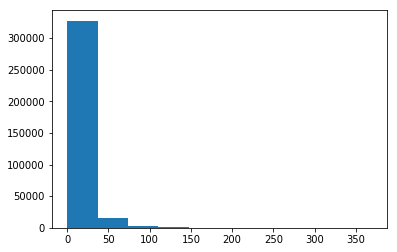

In [65]:

#Age_at_DisbursalDate & Date.of.Birth
categorical_variable_data["Date.of.Birth"] = pd.to_datetime(categorical_variable_data["Date.of.Birth"])
categorical_variable_data["DisbursalDate"] = pd.to_datetime(categorical_variable_data["DisbursalDate"])
categorical_variable_data["Age_at_DisbursalDate"] =  categorical_variable_data["DisbursalDate"] - categorical_variable_data["Date.of.Birth"]
categorical_variable_data["Age_at_DisbursalDate"] = round(categorical_variable_data["Age_at_DisbursalDate"]/np.timedelta64(1,'M'))

#AVERAGE.ACCT.AGE
df = categorical_variable_data["AVERAGE.ACCT.AGE"].str.split(expand=True)
df1 = df[0].str.split('yrs',expand=True)
df2 = df[1].str.split('mon',expand=True)
df1[0] = df1[0].astype(int)
df2[0] = df2[0].astype(int)
df["Avg_Acc_Age_Months"] = (df1[0]*12) + df2[0]
categorical_variable_data["Avg_Acc_Age_Months"] = df["Avg_Acc_Age_Months"]
pd.concat([categorical_variable_data,df["Avg_Acc_Age_Months"]],axis=1)

#AVERAGE.ACCT.AGE is the the avg tenure of loan repayment. Mostly bank prefer loan repayment below 5 years
print("Min Avg_Acc_Age_Months:",categorical_variable_data["Avg_Acc_Age_Months"].min()/12)
print("Max Avg_Acc_Age_Months:",categorical_variable_data["Avg_Acc_Age_Months"].max()/12)
print("More than 5 Years records:",len(categorical_variable_data.loc[categorical_variable_data["Avg_Acc_Age_Months"] >=60]))

# ploting histogram to see distribution of loan tenure
plt.hist(categorical_variable_data["Avg_Acc_Age_Months"]) ## Mostly data falls between 0 to 40 months

# Creating new feature, if greater than 5 years then "least_pref" else "Most_pref"
categorical_variable_data["Loan_tenure"] = 'least_pref'
categorical_variable_data.loc[categorical_variable_data["Avg_Acc_Age_Months"] <= 60,"Loan_tenure"] ="most_pref"

#CREDIT.HISTORY.LENGTH
df = categorical_variable_data["CREDIT.HISTORY.LENGTH"].str.split(expand=True)
df1 = df[0].str.split('yrs',expand=True)
df2 = df[1].str.split('mon',expand=True)
df1[0] = df1[0].astype(int)
df2[0] = df2[0].astype(int)
df["Credit_hist_len_Month"] = (df1[0]*12) + df2[0]
categorical_variable_data = pd.concat([categorical_variable_data,df["Credit_hist_len_Month"]],axis=1)


In [66]:

#categorical_variable_data["Credit_hist_len_Month"].head()
categorical_variable_data.columns.unique()


Index(['Date.of.Birth', 'Employment.Type', 'DisbursalDate',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'loan_default', 'Pri_amt_difference',
       'Age_at_DisbursalDate', 'Avg_Acc_Age_Months', 'Loan_tenure',
       'Credit_hist_len_Month'],
      dtype='object')

In [67]:
# Longer the credit history higher chance of repayment
print("Min Credit_hist_len_Month:",categorical_variable_data["Credit_hist_len_Month"].min())
print("Max Credit_hist_len_Month:",categorical_variable_data["Credit_hist_len_Month"].max())

#Checking distribution
#plt.hist(categorical_variable_data["Credit_hist_len_Month"])

# Creating new feature i.e. Credit_hist_cat
categorical_variable_data["Credit_hist_cat"] = "Low"
categorical_variable_data.loc[categorical_variable_data["Credit_hist_len_Month"] <= 48,"Credit_hist_cat"] = "Low"
categorical_variable_data.loc[categorical_variable_data["Credit_hist_len_Month"] > 48,"Credit_hist_cat"] = "Medium"
categorical_variable_data.loc[categorical_variable_data["Credit_hist_len_Month"] > 96,"Credit_hist_cat"] = "High"

Min Credit_hist_len_Month: 0
Max Credit_hist_len_Month: 468


In [68]:
# PERFORM_CNS.SCORE.DESCRIPTION - it has 20 levels. Reducing the levels

categorical_variable_data["Perform_Score"] = 'No Score'
categorical_variable_data.loc[categorical_variable_data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High'),'Perform_Score'] = "High"
categorical_variable_data.loc[categorical_variable_data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very High'),'Perform_Score'] = "Very High"
categorical_variable_data.loc[categorical_variable_data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low'),'Perform_Score'] = "Low"
categorical_variable_data.loc[categorical_variable_data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very Low'),'Perform_Score'] = "Very Low"
categorical_variable_data.loc[categorical_variable_data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium'),'Perform_Score'] = "Medium"



min age:  -611.0
max age:  599.0
% of Negative Age: 8.596539968629358


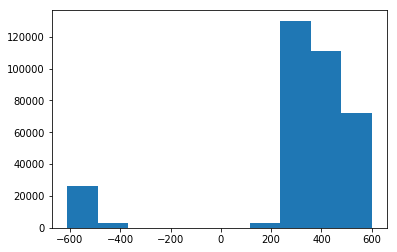

In [69]:
#Analyzing age of candidates

print("min age: ",categorical_variable_data["Age_at_DisbursalDate"].min()) #-611.0
print("max age: ",categorical_variable_data["Age_at_DisbursalDate"].max()) #599.0

#Noticed Age_at_DisbursalDate has negative values, which should not be the case. 
print("% of Negative Age:",len(categorical_variable_data.loc[categorical_variable_data["Age_at_DisbursalDate"] <= 0])/len(categorical_variable_data)*100)
# % of Negative Age: 8.520548650248335

#Plot histogram to see distribution of age
plt.hist(categorical_variable_data["Age_at_DisbursalDate"])

#people in the age group of 30-50 years are most preferred as they are considered more financially stable.
#Based on above statement below categories has decided
categorical_variable_data["Preferred_Age"] = 'Negative'
categorical_variable_data.loc[categorical_variable_data["Age_at_DisbursalDate"] > 100,  "Preferred_Age"] = "least_pref"
categorical_variable_data.loc[categorical_variable_data["Age_at_DisbursalDate"] >= 336, "Preferred_Age"] = "most_pref"


In [70]:
categorical_variable_data.head()

,Date.of.Birth,Employment.Type,DisbursalDate,PERFORM_CNS.SCORE.DESCRIPTION,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,loan_default,Pri_amt_difference,Age_at_DisbursalDate,Avg_Acc_Age_Months,Loan_tenure,Credit_hist_len_Month,Credit_hist_cat,Perform_Score,Preferred_Age
0,1984-01-01,Salaried,2018-03-08,No Bureau History Available,0yrs 0mon,0yrs 0mon,1,0,0,0,0,1,410.0,0,most_pref,0,Low,No Score,most_pref
1,1985-07-31,Self employed,2018-09-26,I-Medium Risk,1yrs 11mon,1yrs 11mon,1,0,0,0,1,1,398.0,23,most_pref,23,Low,Medium,most_pref
2,1985-08-24,Self employed,2018-01-08,No Bureau History Available,0yrs 0mon,0yrs 0mon,1,0,0,0,0,1,389.0,0,most_pref,0,Low,No Score,most_pref
3,1993-12-30,Self employed,2018-10-26,L-Very High Risk,0yrs 8mon,1yrs 3mon,1,0,0,0,1,1,298.0,8,most_pref,15,Low,Very High,least_pref
4,1977-09-12,Self employed,2018-09-26,No Bureau History Available,0yrs 0mon,0yrs 0mon,1,0,0,0,1,1,492.0,0,most_pref,0,Low,No Score,most_pref


In [ ]:
# Moving recently created numeric features in Numeric data set
#numeric_variable_data_new = pd.concat([numeric_variable_data_new ,categorical_variable_data[["Age_at_DisbursalDate","Avg_Acc_Age_Months","Credit_hist_len_Month"]]],axis=1)


### Final categorical Data

In [71]:
# Creating another copy of categorical data with selected varaibles
rm_vars = (["Date.of.Birth", "DisbursalDate","AVERAGE.ACCT.AGE","CREDIT.HISTORY.LENGTH","Age_at_DisbursalDate"
            ,"Avg_Acc_Age_Months","Credit_hist_len_Month","PERFORM_CNS.SCORE.DESCRIPTION","loan_default"])
all_vars = list(categorical_variable_data)
var_list=[col for col in all_vars if col not in rm_vars]
categorical_variable_data_new = categorical_variable_data[var_list]

### Final Numeric Data

In [76]:
#Removing Id Vars & fine classed vars from Numeric Dataset
rm_var = (["UniqueID","Employee_code_ID","PERFORM_CNS.SCORE","PRI.NO.OF.ACCTS","PRI.ACTIVE.ACCTS","PRI.OVERDUE.ACCTS"
           ,"SEC.NO.OF.ACCTS","SEC.ACTIVE.ACCTS","SEC.OVERDUE.ACCTS","NEW.ACCTS.IN.LAST.SIX.MONTHS"
           , "DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS", "NO.OF_INQUIRIES","loan_default"])


all_vars = list(numeric_variable_data_new)
var_list = [col for col in all_vars if col not in rm_var]

rm_var = list(categorical_variable_data_new)
var_list = [col for col in var_list if col not in rm_var]
numeric_variable_data_new_1 = numeric_variable_data_new[var_list]


In [77]:
categorical_variable_data_new.head()

,Employment.Type,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Pri_amt_difference,Loan_tenure,Credit_hist_cat,Perform_Score,Preferred_Age
0,Salaried,1,0,0,0,1,most_pref,Low,No Score,most_pref
1,Self employed,1,0,0,0,1,most_pref,Low,Medium,most_pref
2,Self employed,1,0,0,0,1,most_pref,Low,No Score,most_pref
3,Self employed,1,0,0,0,1,most_pref,Low,Very High,least_pref
4,Self employed,1,0,0,0,1,most_pref,Low,No Score,most_pref


In [78]:
numeric_variable_data_new_1.head() 

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT
0,50578,58400,89.55,67,22807,45,1441,6,0,0,0,0
1,47145,65550,73.23,67,22807,45,1502,6,27600,50200,50200,1991
2,53278,61360,89.63,67,22807,45,1497,6,0,0,0,0
3,57513,66113,88.48,67,22807,45,1501,6,0,0,0,31
4,52378,60300,88.39,67,22807,45,1495,6,0,0,0,0


In [79]:
fine_classing_data.head()

,loan_default,cat_PRI.NO.OF.ACCTS,cat_PRI.ACTIVE.ACCTS,cat_PRI.OVERDUE.ACCTS,cat_SEC.NO.OF.ACCTS,cat_SEC.ACTIVE.ACCTS,cat_SEC.OVERDUE.ACCTS,cat_SEC.INSTAL.AMT,cat_NEW.ACCTS.IN.LAST.SIX.MONTHS,cat_DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,cat_NO.OF_INQUIRIES
0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
1,1.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0
2,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0
3,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0
4,1.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0


### One hot encoding for Categorical data

In [80]:
#One Hot encoding for cat Variables
cate_ohe = pd.get_dummies(categorical_variable_data_new)

### Creating final data for modelling

In [81]:
#Creating final Data
final_model_data = pd.concat([numeric_variable_data_new_1,fine_classing_data,cate_ohe],axis = 1)
final_model_data.head()


,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,...,Credit_hist_cat_Medium,Perform_Score_High,Perform_Score_Low,Perform_Score_Medium,Perform_Score_No Score,Perform_Score_Very High,Perform_Score_Very Low,Preferred_Age_Negative,Preferred_Age_least_pref,Preferred_Age_most_pref
0,50578,58400,89.55,67,22807,45,1441,6,0,0,...,0,0,0,0,1,0,0,0,0,1
1,47145,65550,73.23,67,22807,45,1502,6,27600,50200,...,0,0,0,1,0,0,0,0,0,1
2,53278,61360,89.63,67,22807,45,1497,6,0,0,...,0,0,0,0,1,0,0,0,0,1
3,57513,66113,88.48,67,22807,45,1501,6,0,0,...,0,0,0,0,0,1,0,0,1,0
4,52378,60300,88.39,67,22807,45,1495,6,0,0,...,0,0,0,0,1,0,0,0,0,1


### Splitting merged Train and Test data

In [82]:
#Separate train and test data
train_df = final_model_data[(final_model_data["loan_default"]==1) | (final_model_data["loan_default"]==0)]
test_df  = final_model_data[(final_model_data["loan_default"]!=1) & (final_model_data["loan_default"]!=0)]
test_df.drop("loan_default", axis = 1, inplace =True)

C:\Users\Gaurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [83]:
#Changing data type of target variable
train_df['loan_default'] = train_df['loan_default'].astype(int)

C:\Users\Gaurav\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Creating Train and Test data from Actual Train data

In [86]:
x_train_test = train_df[train_df.columns.difference(['loan_default'])]
y_train_test = train_df[['loan_default']]


x_train, x_test, y_train, y_test = train_test_split(x_train_test, y_train_test, test_size = 0.3,
                                                        stratify = y_train_test.loan_default, random_state = 1)
print("x_train",len(x_train))
print("x_test",len(x_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

x_train 163207
x_test 69947
y_train 163207
y_test 69947


In [87]:
#Checking event rate Train data
events = y_train.groupby("loan_default").size()
print("Zero Event:",events[0]/len(x_train))
print("One Event:",events[1]/len(x_train))


Zero Event: 0.78292597744
One Event: 0.21707402256


In [88]:
#Checking event rate Test data
events = y_test.groupby("loan_default").size()
print("Zero Event:",events[0]/len(y_test))
print("One Event:",events[1]/len(y_test))

Zero Event: 0.782935651279
One Event: 0.217064348721


### Modelling - Random Forest

In [89]:
 # Random Forest Code. Tunegrid all the parameters to get the optimal one

pipeline = Pipeline([('clf', RandomForestClassifier(random_state=42))])
ncol_sqrt = round(x_train.shape[1]**0.5)
parameters = {
    'clf__max_depth': (4,6,8),
    'clf__n_estimators': (30, 60, 100),
    'clf__criterion':('gini','entropy'),
    'clf__max_features': range(5,(ncol_sqrt+1)),
    'clf__class_weight': ({1:0.5,0:0.5},{1:0.6,0:0.4},{1:0.4,0:0.6})}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(x_train,y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters set:')
best_parameters = grid_search.best_estimator_.get_params()
#Best score: 0.7830362668267905

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 486 out of 486 | elapsed: 28.8min finished
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Best score: 0.7832752271655015
Best parameters set:


In [90]:
params = {}
for param_name in sorted(parameters.keys()):
    params[param_name[5:]]=best_parameters[param_name]
    print('\t {}: {}'.format(param_name[5:], best_parameters[param_name]))
params

	 class_weight: {1: 0.6, 0: 0.4}
	 criterion: entropy
	 max_depth: 8
	 max_features: 6
	 n_estimators: 30


{'class_weight': {0: 0.4, 1: 0.6},
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 6,
 'n_estimators': 30}

In [91]:
# Building the model with optimal parameter
rf = RandomForestClassifier(n_estimators = 30,
                            criterion = 'entropy',
                            max_features = 6,
                            max_depth = 8,
                            bootstrap = True,
                            oob_score = True,
                            class_weight = 'balanced_subsample')
rf.fit(x_train, y_train.loan_default)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=8, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [92]:
# ROC-AUC on train data
print("ROC-AUC on train data: ",float(roc_auc_score(y_train.loan_default, rf.predict_proba(x_train)[::,1])))

# ROC-AUC on test data
print("ROC-AUC on test data: ",float(roc_auc_score(y_test.loan_default, rf.predict_proba(pd.DataFrame(x_test))[::,1])))

#ROC-AUC on train data:  0.6687605716715135
#ROC-AUC on test data:  0.6463641462069648

ROC-AUC on train data:  0.6655334064141665
ROC-AUC on test data:  0.6448362168143253


In [93]:
print(x_train.shape)
print(x_test.shape)

(163207, 44)
(69947, 44)


In [94]:
! pip install tabulate

You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [95]:
# Extracting feature importance
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [96]:
feature_importances


,importance
ltv,0.172182
disbursed_amount,0.125536
Perform_Score_Very Low,0.084548
Current_pincode_ID,0.061409
State_ID,0.051611
PRI.DISBURSED.AMOUNT,0.047012
PRI.SANCTIONED.AMOUNT,0.045659
asset_cost,0.037342
PRI.CURRENT.BALANCE,0.035195
Pri_amt_difference,0.034021


In [97]:
from sklearn.feature_selection import SelectFromModel
var_idx = SelectFromModel(rf, threshold = 0.006684, prefit = True).get_support()
var_names = x_train.columns[var_idx]
var_names

Index(['Aadhar_flag', 'Credit_hist_cat_Low', 'Current_pincode_ID',
       'Employment.Type_Salaried', 'PRI.CURRENT.BALANCE',
       'PRI.DISBURSED.AMOUNT', 'PRI.SANCTIONED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'Perform_Score_High', 'Perform_Score_Very High',
       'Perform_Score_Very Low', 'Preferred_Age_least_pref',
       'Pri_amt_difference', 'State_ID', 'VoterID_flag', 'asset_cost',
       'branch_id', 'cat_DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'cat_NO.OF_INQUIRIES', 'cat_PRI.ACTIVE.ACCTS', 'cat_PRI.OVERDUE.ACCTS',
       'disbursed_amount', 'ltv', 'manufacturer_id', 'supplier_id'],
      dtype='object')

In [98]:
# Rebuilding the model with significant variable
rf_trimmed = RandomForestClassifier(n_estimators = 30,
                            criterion = 'entropy',
                            max_features = 6,
                            max_depth = 8,
                            bootstrap = True,
                            oob_score = True,
                            class_weight = 'balanced_subsample')
rf_trimmed.fit(SelectFromModel(rf, threshold = 0.006684, prefit = True).transform(x_train), y_train.loan_default)

C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=8, max_features=6,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [115]:
# ROC-AUC on train data 
RF_Train_ROC_AUC = float(roc_auc_score(y_train.loan_default, rf_trimmed.predict_proba(pd.DataFrame(SelectFromModel(rf, threshold = 0.006684, prefit = True).transform(x_train)))[::,1]))

# ROC-AUC on test data
RF_Test_ROC_AUC = float(roc_auc_score(y_test.loan_default, rf_trimmed.predict_proba(pd.DataFrame(SelectFromModel(rf, threshold = 0.006684, prefit = True).transform(x_test)))[::,1]))

print("RF_Train_ROC_AUC:",RF_Train_ROC_AUC)
print("RF_Test_ROC_AUC:",RF_Test_ROC_AUC)
#ROC-AUC on train data:  0.6687605716715135
#ROC-AUC on test data:  0.6463641462069648

RF_Train_ROC_AUC: 0.6654084872193761
RF_Test_ROC_AUC: 0.6436535763935628


In [135]:
test_df_final = test_df[var_names]

### XGBoost

In [116]:
import xgboost as xgb
from xgboost import XGBClassifier

In [138]:
#Defining XGB function
def xgb_classifier(x_train, x_test, y_train, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=8,
                        min_child_weight=6, gamma=0.2, subsample=0.7, colsample_bytree=0.3,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
        
    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(x_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print('Start Training')
    alg.fit(x_train, y_train, eval_metric='auc')
    
    #Predict test set:
    print("Start Predicting")
    predictions_test = alg.predict(x_test)
    pred_proba_test = alg.predict_proba(x_test)[:, 1]
    
    predictions_train = alg.predict(x_train)
    pred_proba_train = alg.predict_proba(x_train)[:, 1]
    
    accuracy_score = metrics.accuracy_score(y_test, predictions_test)
    XGB_roc_auc_score_test = metrics.roc_auc_score(y_test, pred_proba_test)
    XGB_roc_auc_score_train = metrics.roc_auc_score(y_train, pred_proba_train)   
    F1_Score = metrics.f1_score(y_test, predictions_test)
    
    #Print model report:
    print("accuracy_score:", accuracy_score)
    print("XGB_roc_auc_score_test:",XGB_roc_auc_score_test)
    print("XGB_roc_auc_score_train",XGB_roc_auc_score_train)   
    print("F1 Score" , F1_Score) 

#Calling XGB functuion
xgb_classifier(x_train_sc, x_test_sc, y_train, y_test)



Start Feeding Data
Start Training


C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start Predicting
accuracy_score: 0.783150099361
XGB_roc_auc_score_test: 0.659973803492
XGB_roc_auc_score_train 0.730949941141
F1 Score 0.0238125884927


### Tuning XGB Parameters

#### Max_depth and Min_child_weight

In [122]:
#Tunning XGB parameters
#Tune max_depth and min_child_weight
# Taking wide range for max_depth and min_child_weight
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=8,
                                                  min_child_weight=6, gamma=0.2, subsample=0.7, colsample_bytree=0.3,
                                                  objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(x_train,y_train)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


SyntaxError: invalid syntax (<ipython-input-122-5fe6836f09f9>, line 11)

In [123]:
# In above exection we have identified best 'max_depth': 7, 'min_child_weight': 5.  Below we are going one more step deeper
param_test2 = {
             'max_depth':[7,8,9],
             'min_child_weight':[5,6,7]
            }

gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=8,
                                                 min_child_weight=6, gamma=0.2, subsample=0.7, colsample_bytree=0.3,
                                                 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
                                                 

gsearch2.fit(x_train,y_train)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_


C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.65428, std: 0.00253, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.65433, std: 0.00230, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.65435, std: 0.00240, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.65935, std: 0.00238, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.65956, std: 0.00193, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.65936, std: 0.00246, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.65992, std: 0.00175, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.66075, std: 0.00190, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.66109, std: 0.00179, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.65834, std: 0.00226, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.65807, std: 0.00127, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.65992, std: 0.00124, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 5

#### Gamma

In [125]:
#Tune gamma
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=7,
                                                 min_child_weight=5, gamma=0.2, subsample=0.7, colsample_bytree=0.3,
                                                 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                                                 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(x_train,y_train)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.66075, std: 0.00249, params: {'gamma': 0.0},
  mean: 0.66075, std: 0.00180, params: {'gamma': 0.1},
  mean: 0.66109, std: 0.00179, params: {'gamma': 0.2},
  mean: 0.66124, std: 0.00221, params: {'gamma': 0.3},
  mean: 0.66137, std: 0.00193, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.66136808108254785)

#### Subsample and colsample_bytree

In [126]:
#Tune subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(4,8)],
 'colsample_bytree':[i/10.0 for i in range(1,4)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=7,
                                                 min_child_weight=5, gamma=0.4, subsample=0.6, colsample_bytree=0.1,
                                                 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                         param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(x_train,y_train)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_


C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.65691, std: 0.00297, params: {'colsample_bytree': 0.1, 'subsample': 0.4},
  mean: 0.65741, std: 0.00324, params: {'colsample_bytree': 0.1, 'subsample': 0.5},
  mean: 0.65775, std: 0.00177, params: {'colsample_bytree': 0.1, 'subsample': 0.6},
  mean: 0.65851, std: 0.00213, params: {'colsample_bytree': 0.1, 'subsample': 0.7},
  mean: 0.65895, std: 0.00212, params: {'colsample_bytree': 0.2, 'subsample': 0.4},
  mean: 0.65873, std: 0.00231, params: {'colsample_bytree': 0.2, 'subsample': 0.5},
  mean: 0.66037, std: 0.00095, params: {'colsample_bytree': 0.2, 'subsample': 0.6},
  mean: 0.66093, std: 0.00208, params: {'colsample_bytree': 0.2, 'subsample': 0.7},
  mean: 0.65892, std: 0.00167, params: {'colsample_bytree': 0.3, 'subsample': 0.4},
  mean: 0.65958, std: 0.00205, params: {'colsample_bytree': 0.3, 'subsample': 0.5},
  mean: 0.66054, std: 0.00142, params: {'colsample_bytree': 0.3, 'subsample': 0.6},
  mean: 0.66137, std: 0.00193, params: {'colsample_bytree': 0.3, 'subsample'

### Applying tuned parameters

In [128]:

#Defining XGB function with updated tunned parameter
def xgb_classifier_1(x_train, x_test, y_train, y_test, useTrainCV = True, cv_folds=5, early_stopping_rounds=50):
    alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=7,
                        min_child_weight=5, gamma=0.4, subsample=0.7, colsample_bytree=0.3, 
                        objective='binary:logistic', nthread= 4, scale_pos_weight=1, seed=27)
    if useTrainCV:
        print("Start Feeding Data")
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        # xgtest = xgb.DMatrix(x_test.values, label=y_test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    print('Start Training')
    alg.fit(x_train, y_train, eval_metric='auc')
    
    #Predict test set:
    print("Start Predicting")
    predictions_test = alg.predict(x_test)
    pred_proba_test = alg.predict_proba(x_test)[:, 1]
    
    predictions_train = alg.predict(x_train)
    pred_proba_train = alg.predict_proba(x_train)[:, 1]
    
    #Print model report:
    accuracy_score = metrics.accuracy_score(y_test, predictions_test)
    XGB_roc_auc_score_test = metrics.roc_auc_score(y_test, pred_proba_test)
    XGB_roc_auc_score_train = metrics.roc_auc_score(y_train, pred_proba_train)   
    F1_Score = metrics.f1_score(y_test, predictions_test)
    
    print("accuracy_score:", accuracy_score)
    print("XGB_roc_auc_score_test:",XGB_roc_auc_score_test)
    print("XGB_roc_auc_score_train",XGB_roc_auc_score_train)   
    print("F1 Score" , F1_Score)

#Calling XGB functuiontrain_all_sc.values
xgb_classifier_1(x_train, x_test, y_train, y_test)

Start Feeding Data
Start Training


C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Gaurav\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Start Predicting
accuracy_score: 0.783293064749
XGB_roc_auc_score_test: 0.6596515944
XGB_roc_auc_score_train 0.710547712712
F1 Score 0.0191536171865


In [142]:
# Training and fititng XGB on all data

#Using all training data for Training purpose
train_all = train_df[var_names]
y_train_all = train_df["loan_default"]

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_all_sc = sc.fit_transform(train_all)

alg = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=7,
                        min_child_weight=5, gamma=0.4, subsample=0.7, colsample_bytree=0.3, 
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
                        

print("Start Feeding Data")
xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(train_all_sc, label=y_train_all.values)
# xgtest = xgb.DMatrix(x_test.values, label=y_test.values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=5,
                  early_stopping_rounds=50)
alg.set_params(n_estimators=cvresult.shape[0])

print('Start Training')
alg.fit(train_all_sc, y_train_all, eval_metric='auc')




Start Feeding Data
Start Training


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=7, min_child_weight=5, missing=None,
       n_estimators=56, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=27, silent=True, subsample=0.7)

### Final Prediction

In [144]:
#Prediction on Test Data
print("Start Predicting")
pred_proba = alg.predict_proba(test_df_final_sc)[:, 1]
#pred_proba = alg.predict(test_df_final)
test["loan_default"] = pred_proba
#Creating Output File
test[["UniqueID","loan_default"]].to_csv("D:\\Statastics\\Analytics Vidhya\\L&T - Vehicle Loan Default\\XGB_Output_10.csv")

Start Predicting
